In [1]:
from absl import app, flags, logging
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import h5py
import  PIL
import scipy.io as spio
from os import listdir, path
from os.path import isfile, join
import cv2
from yolov3_tf2.dataset import transform_images
import tensorflow as tf
import os
import cv2
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny, YoloLoss,
    yolo_anchors, yolo_anchor_masks,
    yolo_tiny_anchors, yolo_tiny_anchor_masks
)
from yolov3_tf2.utils import freeze_all
import yolov3_tf2.dataset as dataset
from sklearn.model_selection import train_test_split

In [2]:
#Convert Yolo-v3-tf2 format (Differ from 
#Yolo Original (x,y,w,h), here xmin, ymin, xmax, ymax)
def convert_xy(data,shape):
    h,w=shape
    for i in range(0,len(data)):
        xmin=data[i][0]/w
        ymin=data[i][1]/h
        xmax=(data[i][0]+data[i][2])/w
        ymax=(data[i][1]+data[i][3])/h
        data[i]=xmin,ymin,xmax,ymax
    return data

def getwh(im):
    h,w=im.shape[0],im.shape[1]
    return(h,w)

# def convert(size, box):
    # dw = 1./size[0]
    # dh = 1./size[1]
    # x = (box[0] + box[1])/2.0
    # y = (box[2] + box[3])/2.0
    # w = box[1] - box[0]
    # h = box[3] - box[2]
    # x = x*dw
    # w = w*dw
    # y = y*dh
    # h = h*dh
    # return (x,y,w,h)

In [3]:
###fonctions to check data yolo format validity
## ex: draw_boxes(img,labels,shape)
def from_yolo_to_cor(box, shape):
    img_h, img_w, _ = shape
    # x1, y1 = ((x + witdth)/2)*img_width, ((y + height)/2)*img_height
    # x2, y2 = ((x - witdth)/2)*img_width, ((y - height)/2)*img_height
    x1, y1 = int((box[0] + box[2]/2)*img_w), int((box[1] + box[3]/2)*img_h)
    x2, y2 = int((box[0] - box[2]/2)*img_w), int((box[1] - box[3]/2)*img_h)
    return x1, y1, x2, y2
    
def draw_boxes(img, boxes,shape):
    for box in boxes:
        x1, y1, x2, y2 = from_yolo_to_cor(box, shape)
        print(x1,y1,x2,y2)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 3)
    plt.imshow(img)
    return

In [4]:
dataFiles = [f for f in listdir('./data/polar_car_set/Annotations/') if isfile(join('./data/polar_car_set/Annotations/', f))]

dataImages=[f for f in listdir('./data/polar_car_set/Images/')]


In [5]:
#Loading Images and saving them in a list
images=[]
for j in range(0,len(dataImages)):
    imgpil=PIL.Image.open('./data/polar_car_set/Images/{0}/0.jpg'.format(dataImages[j]),'r')
    im = np.array(imgpil)
    images.append(im)

In [6]:
###LOADING LABELS in a dict
datas=[]
labels={}
for j in range(0,len(dataFiles)):
    label=[]
    myPATH='./data/polar_car_set/Annotations/{0}'.format(dataFiles[j])      
    matrix='{0}_crop'.format(dataFiles[j][0:-4])
    f = h5py.File(myPATH,'r')
    data = f.get(matrix)
    data = np.array(data)
    data=data[0:4]
    data=data.T
    data=convert_xy(data,getwh(images[j]))
    data=np.c_[data,np.zeros(len(data))]
    # h,w=getwh(images[j])
    tmp=[]
    labels[j]=data
    # for i in range(0,len(data)):
        ### UNCOMMENT THOSE LINES and convert(),then modify 
        ###convert_xy() to have original yolo labels formats
    #     label=np.asarray(convert((w,h),data[i]))
    #     tmp.append(label)
    #     temp=np.c_[tmp,np.zeros(len(tmp))]  
    #     labels[j]=temp
    # datas.append(data)
### adding nb box max for each images    
nb_max_box=50
list_labels=[]
for i in labels.values():
    i=np.concatenate((i,np.zeros((nb_max_box-i.shape[0],5)))).astype("float32")
    list_labels.append(i)
list_labels=np.asarray(list_labels)

In [7]:
#### Concatenation of 3 images of size (416,416,3) in one of size (416,416,9)

dataImages=[f for f in listdir('./data/polar_car_set/Images')]
polar=['0','45','90']
data9chan=[]
for j in range(len(dataImages)):
    tmp=[]
    for l in range(len(polar)):    
        
        img = tf.image.decode_image(open('./data/polar_car_set/Images/{0}/{1}.jpg'.format(dataImages[j],
                                         polar[l]), 'rb').read(), channels=3)        

        img = transform_images(img, 416)

        tmp.append(img)
    tmp9chan=np.concatenate((tmp[0],tmp[1],tmp[2]),axis=2)
    data9chan.append(tmp9chan)

data_list=data9chan
   
data_Array=np.asarray(data9chan,dtype='float32')

In [8]:
### reintegration of polarimetric element inside the image of size (416,416*3,3)

data_Array=data_Array.reshape(data_Array.shape[0],data_Array.shape[1],data_Array.shape[2]*3,3)


In [9]:
###Split data into train test val sets

x_train, x_test, y_train, y_test = train_test_split(
        data_Array, list_labels, test_size=0.1, random_state=100,shuffle=True)

x_train, x_val, y_train, y_val= train_test_split(
        x_train, y_train, test_size=0.08, random_state=100,shuffle=True)

In [10]:
print("Train set shape X: "+str(x_train.shape)+"\t Y: "+str(y_train.shape))
print("Test set shape X: "+str(x_test.shape)+"\t Y: "+str(y_test.shape))
print("Val set shape X: "+str(x_val.shape)+"\t Y: "+str(y_val.shape))

Train set shape X: (125, 416, 1248, 3)	 Y: (125, 50, 5)
Test set shape X: (16, 416, 1248, 3)	 Y: (16, 50, 5)
Val set shape X: (11, 416, 1248, 3)	 Y: (11, 50, 5)


In [11]:
#loading model to train
model = YoloV3(832, channels=3,training=True, classes=2)
anchors = yolo_anchors
anchor_masks = yolo_anchor_masks

In [12]:
#loading data to Tensors
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)) 
train_dataset = train_dataset.shuffle(buffer_size=128)

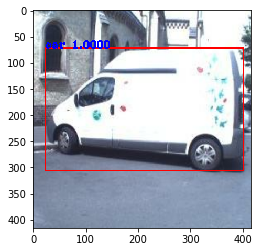

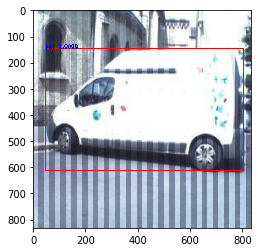

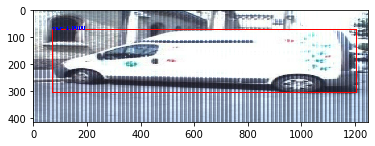

In [32]:
####visualise dataset
%load_ext matplotlib inline
class_names = [c.strip() for c in open('./data/car.names').readlines()]
from yolov3_tf2.utils import draw_outputs
for image, labels in train_dataset.take(1):
    boxes = []
    scores = []
    classes = []
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    img=tf.image.resize(image.numpy(), (416, 416))
    img=np.asarray(img)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    plt.imshow(img)
    plt.show()
    
    img=tf.image.resize(image.numpy(), (832, 832))
    img=np.asarray(img)
    img=img*255
    img=img.astype(int)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    plt.imshow(img)
    plt.show()
    
    img=image.numpy()
    img=img*255
    img=img.astype(int)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    plt.imshow(img)
    plt.show()

In [13]:
train_dataset = train_dataset.batch(1)
train_dataset = train_dataset.map(lambda x, y: ( tf.image.resize(x, (832, 832)),
        dataset.transform_targets(y, anchors, anchor_masks, 832)))
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val)) 
val_dataset = val_dataset.batch(1)
val_dataset = val_dataset.map(lambda x, y: ( tf.image.resize(x, (832, 832)),
        dataset.transform_targets(y, anchors, anchor_masks, 832)))
val_dataset = val_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
### Loading and freeze pretrained model

model_pretrained = YoloV3(416, training=True, classes=80)
model_pretrained.load_weights('./checkpoints/yolov3.tf')


model.get_layer('yolo_darknet').set_weights(
model_pretrained.get_layer('yolo_darknet').get_weights())
freeze_all(model.get_layer('yolo_darknet'))

In [15]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
loss = [YoloLoss(anchors[mask], classes=2)
        for mask in anchor_masks]
model.compile(optimizer=optimizer, loss=loss)

callbacks = [
    ReduceLROnPlateau(verbose=1),
    EarlyStopping(patience=3, verbose=1),
    ModelCheckpoint('checkpoints/yolov3_train_{epoch}.tf',
                    verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]

In [16]:
history = model.fit(train_dataset,
                    epochs=30,
                    callbacks=callbacks,
                    validation_data=val_dataset)


Epoch 1/20
    125/Unknown - 37s 297ms/step - loss: 8741.7238 - yolo_output_0_loss: 405.0295 - yolo_output_1_loss: 1584.8134 - yolo_output_2_loss: 6741.2930
Epoch 00001: saving model to checkpoints/yolov3_train_1.tf
125/125 [==============================] - 46s 365ms/step - loss: 8741.7238 - yolo_output_0_loss: 405.0295 - yolo_output_1_loss: 1584.8134 - yolo_output_2_loss: 6741.2930 - val_loss: 0.0000e+00 - val_yolo_output_0_loss: 0.0000e+00 - val_yolo_output_1_loss: 0.0000e+00 - val_yolo_output_2_loss: 0.0000e+00
Epoch 2/20
124/125 [============================>.] - ETA: 0s - loss: 2290.5917 - yolo_output_0_loss: 62.8727 - yolo_output_1_loss: 327.8340 - yolo_output_2_loss: 1889.2889
Epoch 00002: saving model to checkpoints/yolov3_train_2.tf
125/125 [==============================] - 32s 259ms/step - loss: 2290.5534 - yolo_output_0_loss: 62.6818 - yolo_output_1_loss: 327.0486 - yolo_output_2_loss: 1885.4781 - val_loss: 2510.3019 - val_yolo_output_0_loss: 57.3039 - val_yolo_output_1_lo

Epoch 17/20
124/125 [============================>.] - ETA: 0s - loss: 100.5538 - yolo_output_0_loss: 3.4722 - yolo_output_1_loss: 12.3343 - yolo_output_2_loss: 74.1390
Epoch 00017: saving model to checkpoints/yolov3_train_17.tf
125/125 [==============================] - 32s 256ms/step - loss: 100.5544 - yolo_output_0_loss: 3.5317 - yolo_output_1_loss: 12.3573 - yolo_output_2_loss: 74.1266 - val_loss: 101.3511 - val_yolo_output_0_loss: 8.5697 - val_yolo_output_1_loss: 12.9024 - val_yolo_output_2_loss: 69.2706
Epoch 18/20
124/125 [============================>.] - ETA: 0s - loss: 91.2738 - yolo_output_0_loss: 3.2567 - yolo_output_1_loss: 11.1737 - yolo_output_2_loss: 66.2350
Epoch 00018: saving model to checkpoints/yolov3_train_18.tf
125/125 [==============================] - 32s 254ms/step - loss: 91.2736 - yolo_output_0_loss: 3.2695 - yolo_output_1_loss: 11.1806 - yolo_output_2_loss: 66.1821 - val_loss: 91.1159 - val_yolo_output_0_loss: 7.1928 - val_yolo_output_1_loss: 11.4192 - val_y

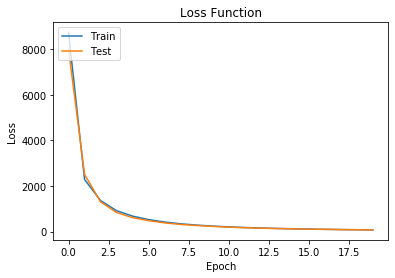

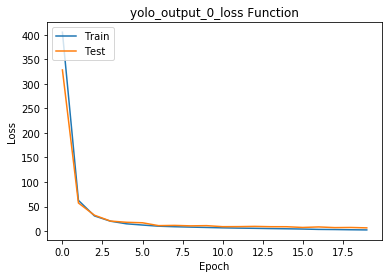

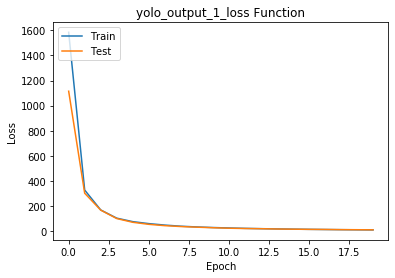

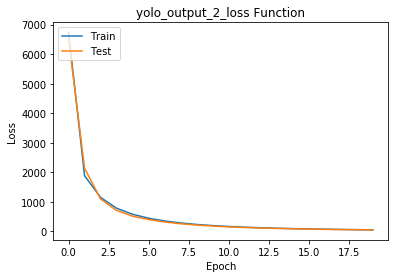

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('Loss Function')
plt.show()

plt.plot(history.history['yolo_output_0_loss'])
plt.plot(history.history['val_yolo_output_0_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('yolo_output_0_loss Function')
plt.show()

plt.plot(history.history['yolo_output_1_loss'])
plt.plot(history.history['val_yolo_output_1_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('yolo_output_1_loss Function')
plt.show()

plt.plot(history.history['yolo_output_2_loss'])
plt.plot(history.history['val_yolo_output_2_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('yolo_output_2_loss Function')
plt.show()

In [22]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 248), started 0:50:46 ago. (Use '!kill 248' to kill it.)